<a href="https://colab.research.google.com/github/Sompote/pile_deep_learning/blob/main/pile_CNN_LSTM_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is for a combindnation of LSTM and CON1D together to predict pile



In [47]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import keras
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/pile_all.csv')

#ks = pd.concat([df, df2,df3]).reset_index(drop=True)

ks=pd.DataFrame()
#ks=df.iloc[::100, :].reset_index(drop=True)
#ks=ks.drop([0])
ks=df
ks[0:30]
x_df=ks.drop('Settlement(mm.)', axis=1)
y_df=ks['Settlement(mm.)']
X=np.array(x_df)
Y=np.array(y_df)

In [5]:
Y.shape

(648,)

In [48]:
#scale data
X_train=X
Y_train=Y
Y_train=np.reshape(Y_train,(-1,1))
sc_y=StandardScaler()
sc = StandardScaler()
sc_f=StandardScaler()

X_train = sc.fit_transform(X_train)
y_train=sc_y.fit_transform(Y_train)

In [12]:
X_train.shape

(648, 9)

In [49]:
# code for setting data as time step with feature

def time_step_data(dataset,timestep):
  from sklearn.preprocessing import MinMaxScaler, StandardScaler
  from sklearn.model_selection import train_test_split
  #output data predict
  datab=timestep
  x_train_time=dataset
  train_data_ini=dataset
  train_data=dataset
  #Create a new dataframe with only the 'Close column
  #scaler = MinMaxScaler(feature_range=(-1,1))
  #train_data = scaler.fit_transform(train_data_ini)
  x_train = []
  x_train_final=np.array([])

  data_length=train_data.shape[0]
  x_train = []
  train_data=x_train_time[:,0]
  for i in range(datab, data_length+1):
    x_train.append(train_data[i-datab:i])
  x_train_a = np.array(x_train)
  x_train_a = np.reshape(x_train_a, (x_train_a.shape[0], x_train_a.shape[1],1))
  x_train_final=x_train_a


  for a in range(1,x_train_time.shape[1]):
    x_train = []
    train_data=x_train_time[:,a]
    for i in range(datab, data_length+1):
      x_train.append(train_data[i-datab:i])
    x_train_a = np.array(x_train)
    x_train_a = np.reshape(x_train_a, (x_train_a.shape[0], x_train_a.shape[1]))
    x_train_final=np.dstack((x_train_final,x_train_a))
  return x_train_final

time_step=3
data_x=time_step_data(X_train,time_step)
data_y=y_train[time_step-1:,:]

In [50]:
data_x.shape

(646, 3, 9)

In [26]:
data_y.shape

(647, 1)

In [37]:
#split data
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.1)


In [30]:
X_train.shape

(582, 2, 9)

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, Flatten, concatenate
from keras.layers import MaxPooling1D
from keras.layers import LSTM, Dense
from tensorflow.keras.metrics import MeanAbsolutePercentageError




def dens_model(dense_input_shape):
  # Create the dense model
  dense_input = Input(shape=dense_input_shape)
  dense_output = Dense(300, activation='sigmoid')(dense_input)
  dense_output = Dense(100, activation='sigmoid')(dense_output)
  dense_output = Dense(50, activation='linear')(dense_output)
  dense_model = Model(inputs=dense_input, outputs=dense_output)
  return dense_model

def feature_model(dense_input_shape):
  # Create the dense model
  dense_input = Input(shape=dense_input_shape)
  dense_output = Dense(50, activation='sigmoid')(dense_input)
  dense_output = Dense(20, activation='sigmoid')(dense_output)
  dense_output = Dense(5, activation='linear')(dense_output)
  dense_model = Model(inputs=dense_input, outputs=dense_output)
  return dense_model

def CNN_model(cnn_input_shape):
  # Create the CNN model
  cnn_input = Input(shape=cnn_input_shape)
  cnn_output = Conv1D(filters=32, kernel_size=2, activation='relu')(cnn_input)
  cnn_output = Conv1D(filters=32, kernel_size=2, activation='relu')(cnn_output)
  cnn_output = Flatten()(cnn_output)
  cnn_output = Dense(50, activation='linear')(cnn_output)
  cnn_model = Model(inputs=cnn_input, outputs=cnn_output)
  return cnn_model


def LSTM_model(dense_input_shape):
  # Create the dense model
  # Use the function parameter as the input shape
  dense_input = Input(shape=dense_input_shape)
  dense_output = LSTM(100,return_sequences=True)(dense_input)
  dense_output = Dense(100, activation='sigmoid')(dense_output)
  dense_output = Dense(50, activation='linear')(dense_output)
  dense_model = Model(inputs=dense_input, outputs=dense_output)
  return dense_model


def combind_model(dense_model,cnn_model,y_train):
  combined_input_dense = dense_model.output
  combined_input_cnn = cnn_model.output
  combined_input_LSTM = LSTM_model.output
  combined_input = concatenate([combined_input_cnn,combined_input_dense])
  combined_output = Dense(y_train.shape[1], activation='linear')(combined_input)
  combined_model = Model(inputs=[cnn_model.input,dense_model.input], outputs=combined_output)
  return combined_model

def combind_model2(LSTM_model,cnn_model,y_train):
  combined_input_LSTM = LSTM_model.output
  combined_input_cnn = cnn_model.output
  combined_input = concatenate([combined_input_LSTM,combined_input_cnn])
  combined_output = Dense(y_train.shape[1], activation='linear')(combined_input)
  combined_model = Model(inputs=[LSTM_model.input,cnn_model.input], outputs=combined_output)
  return combined_model

def combind_model3(dense_model,y_train):
  combined_input_dense = dense_model.output
  combined_input = dense_model
  combined_output = Dense(y_train.shape[1], activation='linear')(combined_input)
  combined_model = Model(inputs=dense_model.input, outputs=combined_output)
  return combined_model

# Compile and summarize the combined model
#Main program

dense_input_shape = (X_train.shape[1])
cnn_input_shape = (X_train.shape[1],X_train.shape[2])
LSTM_input_shape=(X_train.shape[1],X_train.shape[2])



model_cnn=CNN_model(cnn_input_shape)
model_lstm= LSTM_model(LSTM_input_shape)
model_combind=combind_model2(model_lstm,model_cnn,y_train)
model_combind.compile(optimizer='adam', loss='mae', metrics=['mape'])
model_combind.summary()
from tensorflow.keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='loss', patience=6,restore_best_weights=True)

history=model_combind.fit([X_train, X_train], y_train, epochs=1000, batch_size=40,validation_data=([X_test,X_test], y_test))

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 3, 9)]       0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 3, 9)]       0           []                               
                                                                                                  
 lstm_3 (LSTM)                  (None, 3, 100)       44000       ['input_9[0][0]']                
                                                                                                  
 conv1d_8 (Conv1D)              (None, 2, 32)        608         ['input_8[0][0]']                
                                                                                           

In [52]:
#Main program base model
def combind_model3(dense_model,y_train):
  combined_input_dense = dense_model.output
  combined_input =   combined_input_dense
  combined_output = Dense(y_train.shape[1], activation='linear')(combined_input)
  combined_model = Model(inputs=dense_model.input, outputs=combined_output)
  return combined_model
dense_input_shape = (X_train.shape[1])

model_dense=dens_model(dense_input_shape)
model_combind=combind_model3(dens_model(dense_input_shape),y_train)
model=model_combind.compile(optimizer='adam', loss='mse', metrics=['mape'])

history=model_combind.fit(X_train, y_train, epochs=1000, batch_size=40,validation_data=(X_test, y_test))

Epoch 1/1000
17/17 [==============================] - 1s 15ms/step - loss: 1.0518 - mape: 159.8225 - val_loss: 0.3781 - val_mape: 107.3427
Epoch 2/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.8453 - mape: 105.6853 - val_loss: 0.6388 - val_mape: 254.9642
Epoch 3/1000
17/17 [==============================] - 0s 4ms/step - loss: 0.8664 - mape: 186.5990 - val_loss: 0.4323 - val_mape: 197.7921
Epoch 4/1000
17/17 [==============================] - 0s 6ms/step - loss: 0.7025 - mape: 168.0387 - val_loss: 0.3132 - val_mape: 162.2497
Epoch 5/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.6716 - mape: 185.6965 - val_loss: 0.2875 - val_mape: 162.8567
Epoch 6/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.6354 - mape: 175.1224 - val_loss: 0.3253 - val_mape: 173.4593
Epoch 7/1000
17/17 [==============================] - 0s 5ms/step - loss: 0.6389 - mape: 190.5557 - val_loss: 0.4433 - val_mape: 209.0895
Epoch 8/1000
17/17 [=============

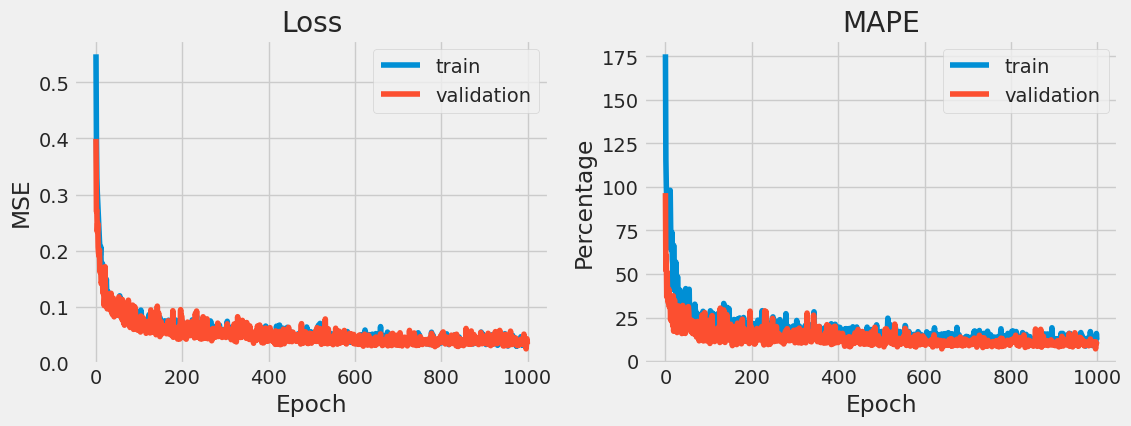

In [44]:

# plot the loss and mape for train and validation sets
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mape'], label='train')
plt.plot(history.history['val_mape'], label='validation')
plt.title('MAPE')
plt.xlabel('Epoch')
plt.ylabel('Percentage')
plt.legend()

plt.show()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 3, 9)]       0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 3, 9)]       0           []                               
                                                                                                  
 lstm_3 (LSTM)                  (None, 3, 100)       44000       ['input_9[0][0]']                
                                                                                                  
 conv1d_8 (Conv1D)              (None, 2, 32)        608         ['input_8[0][0]']                
                                                                                           

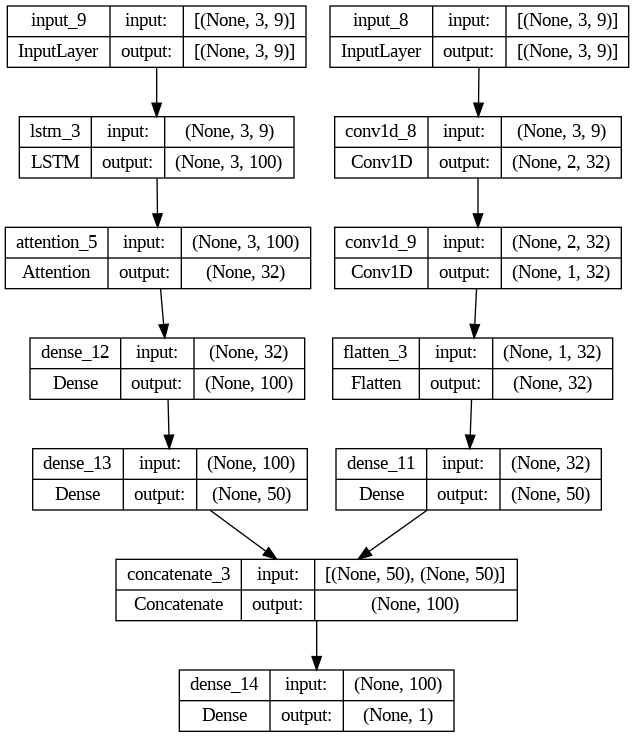

In [51]:
# plot and save your model
import tensorflow as tf
model_combind.summary()
img_file = 'model.png'
tf.keras.utils.plot_model(model_combind, to_file=img_file, show_shapes=True, show_layer_names=True)
